# Time Series Forecasting with FLAML Library

## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models with low computational cost. It is fast and cheap. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can

 - serve as an economical AutoML engine,
 - be used as a fast hyperparameter tuning tool, or
 - be embedded in self-tuning software that requires low latency & resource in repetitive tuning tasks.
 - In this notebook, we demonstrate how to use FLAML library to tune hyperparameters of XGBoost with a regression example.

FLAML requires Python>=3.6. To run this notebook example, please install flaml with the notebook option:

> pip install flaml[notebook]

In [ ]:
!pip install flaml[notebook, forecast]

## 2. Forecast Problem

### Load data and preprocess

Import co2 data from statsmodel. The dataset is from “Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.,” which collected CO2 samples from March 1958 to December 2001. The task is to predict monthly CO2 samples.

In [1]:
import statsmodels.api as sm
data = sm.datasets.co2.load_pandas()
data = data.data
# data is given in weeks, but the task is to predict monthly, so use monthly averages instead
data = data['co2'].resample('MS').mean()
data = data.fillna(data.bfill())  # makes sure there are no missing values
data = data.to_frame().reset_index()
# data = data.rename(columns={'index': 'ds', 'co2': 'y'})

In [2]:
# split the data into a train dataframe and X_test and y_test dataframes, where the number of samples for test is equal to
# the number of periods the user wants to predict
num_samples = data.shape[0]
time_horizon = 12
split_idx = num_samples - time_horizon
X_train = data[:split_idx]  # X_train is a dataframe with two columns: time and value
X_test = data[split_idx:]['index'].to_frame()  # X_test is a dataframe with dates for prediction
y_test = data[split_idx:]['co2']  # y_test is a series of the values corresponding to the dates for prediction

### Run FLAML

In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them.

In [3]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [4]:
settings = {
    "time_budget": 180,  # total running time in seconds
    "metric": 'mape',  # primary metric for validation: 'mape' is generally used for forecast tasks
    "task": 'forecast',  # task type
    "log_file_name": 'CO2_forecast.log',  # flaml log file
    "eval_method": "holdout", # validation method can be chosen from ['auto', 'holdout', 'cv']
    "split_type": 'time' # for foretask task, 'split_type' has to be 'time'
}

In [5]:
'''The main flaml automl API'''
automl.fit(dataframe=X_train,  # training data
           label=('index', 'co2'),  # For 'forecast' task, label should be a tuple of strings for timestamp and value columns
           **settings, 
           period=time_horizon,  # key word argument 'period' must be included for forecast task
           freq='M')

[flaml.automl: 08-30 13:35:18] {1209} INFO - Evaluation method: holdout
[flaml.automl: 08-30 13:35:18] {686} INFO - Using TimeSeriesSplit
[flaml.automl: 08-30 13:35:18] {1237} INFO - Minimizing error metric: mape
[flaml.automl: 08-30 13:35:18] {1259} INFO - List of ML learners in AutoML Run: ['fbprophet', 'arima', 'sarimax']
[flaml.automl: 08-30 13:35:18] {1349} INFO - iteration 0, current learner fbprophet
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[flaml.automl: 08-30 13:35:24] {1502} INFO -  at 6.2s,	best fbprophet's error=0.0007,	best fbprophet's error=0.0007
INFO:flaml.automl: at 6.2s,	best fbprophet's error=0.0007,	best fbprophet's error=0.0007
[flaml.automl: 08-30 13:35:24] {1349} INFO - iteration 1, current learner fbprophet
INFO:flaml.automl:iteration 1, current learner fbprophet
INFO:prophet:Disabling weekly seasonality

### Best model and metric

In [6]:
''' retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print(f'Best mape on validation data: {automl.best_loss}')
print(f'Training duration of best run: {automl.best_config_train_time}s')

Best ML leaner: fbprophet
Best hyperparmeter config: {'changepoint_prior_scale': 0.02876449933617924, 'seasonality_prior_scale': 1.80360430903146, 'holidays_prior_scale': 2.1243991057068654, 'seasonality_mode': 'additive'}
Best mape on validation data: 0.0004765336783587436
Training duration of best run: 4.4560887813568115s


In [7]:
print(automl.model.estimator)

In [8]:
''' pickle and save the automl object '''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [9]:
''' compute predictions of testing dataset '''
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)

Predicted labels 0     370.179589
1     370.897300
2     371.950006
3     373.135219
4     373.634979
5     373.104820
6     371.760649
7     369.848551
8     368.250457
9     368.318975
10    369.517605
11    370.783469
Name: yhat, dtype: float64
True labels          co2
514  370.175
515  371.325
516  372.060
517  372.775
518  373.800
519  373.060
520  371.300
521  369.425
522  367.880
523  368.050
524  369.375
525  371.020


In [10]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('mape', '=', sklearn_metric_loss_score('mape', y_pred, y_test))

mape = 0.0006780276756290267


### Log history

In [11]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=300)

for config in config_history:
    print(config)

{'Current Learner': 'fbprophet', 'Current Sample': 502, 'Current Hyper-parameters': {'changepoint_prior_scale': 0.010000000000000002, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}, 'Best Learner': 'fbprophet', 'Best Hyper-parameters': {'changepoint_prior_scale': 0.010000000000000002, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}}
{'Current Learner': 'fbprophet', 'Current Sample': 502, 'Current Hyper-parameters': {'changepoint_prior_scale': 0.0091602623296037, 'seasonality_prior_scale': 0.8823866403788657, 'holidays_prior_scale': 3.2294014074557995, 'seasonality_mode': 'additive'}, 'Best Learner': 'fbprophet', 'Best Hyper-parameters': {'changepoint_prior_scale': 0.0091602623296037, 'seasonality_prior_scale': 0.8823866403788657, 'holidays_prior_scale': 3.2294014074557995, 'seasonality_mode': 'additive'}}
{'Current Learner': 'fbprophet', 'Current Sample': 502, 'Current Hyper-parameter

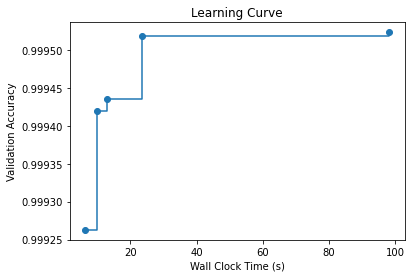

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Comparison with Alternatives

FLAML's MAPE

In [13]:
from flaml.ml import sklearn_metric_loss_score
print('flaml mape', '=', sklearn_metric_loss_score('mape', y_pred, y_test))

flaml mape = 0.0006780276756290267


### Default Prophet

In [14]:
from prophet import Prophet
prophet_model = Prophet()

In [15]:
X_train_prophet = X_train.copy()
X_train_prophet = X_train_prophet.rename(columns={'index': 'ds', 'co2': 'y'})
prophet_model.fit(X_train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
X_test_prophet = X_test.copy()
X_test_prophet = X_test_prophet.rename(columns={'index': 'ds'})
y_pred = prophet_model.predict(X_test_prophet)['yhat']
print('Predicted labels', y_pred)
print('True labels', y_test)
from flaml.ml import sklearn_metric_loss_score
print('default prophet mape', '=', sklearn_metric_loss_score('mape', y_pred, y_test))

Predicted labels 0     370.450675
1     371.177764
2     372.229577
3     373.419835
4     373.914917
5     373.406484
6     372.053428
7     370.149037
8     368.566631
9     368.646853
10    369.863891
11    371.135959
Name: yhat, dtype: float64
True labels          co2
514  370.175
515  371.325
516  372.060
517  372.775
518  373.800
519  373.060
520  371.300
521  369.425
522  367.880
523  368.050
524  369.375
525  371.020
default prophet mape = 0.0011396920680673015


### Auto Arima

In [18]:
# !pip install pmdarima

In [19]:
from pmdarima.arima import auto_arima
import pandas as pd
import time

In [30]:
X_train_arima = X_train.copy()
X_train_arima.index = pd.to_datetime(X_train_arima['index'])
X_train_arima = X_train_arima.drop('index', axis=1)
X_train_arima = X_train_arima.rename(columns={'co2': 'y'})
# use same search space as FLAML
arima_model = auto_arima(X_train_arima, 
                         start_p=2, d=None, start_q=2, max_p=10, max_d=2, max_q=10, 
                         suppress_warnings=True, stepwise=False, seasonal=False, 
                         error_action='ignore', trace=True, n_fits=50)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1638.009, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1344.207, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1222.286, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1174.928, Time=0.18 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1188.947, Time=0.37 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1091.452, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1298.693, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1240.963, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1196.535, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1176.484, Time=0.27 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1180.404, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=990.719, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=988.094, Time=0.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1140.469, Time=0.48 sec
 ARIMA(3,1,0)(0,0

In [31]:
y_pred = arima_model.predict(n_periods = 12)
print('Predicted labels', y_pred)
print('True labels', y_test)
from flaml.ml import sklearn_metric_loss_score
print('auto arima mape', '=', sklearn_metric_loss_score('mape', y_pred, y_test))

Predicted labels [370.79556132 371.7634416  372.13571633 371.90468927 371.24154256
 370.42473739 369.74521422 369.41909493 369.5327542  370.03264528
 370.75760204 371.49907745]
True labels          co2
514  370.175
515  371.325
516  372.060
517  372.775
518  373.800
519  373.060
520  371.300
521  369.425
522  367.880
523  368.050
524  369.375
525  371.020
auto arima mape = 0.003201746906460404


### Auto SARIMA

In [32]:
# !pip install pmdarima

In [33]:
from pmdarima.arima import auto_arima
import pandas as pd
import time

In [34]:
X_train_arima = X_train.copy()
X_train_arima.index = pd.to_datetime(X_train_arima['index'])
X_train_arima = X_train_arima.drop('index', axis=1)
X_train_arima = X_train_arima.rename(columns={'co2': 'y'})
# use same search space as FLAML
arima_model = auto_arima(X_train_arima, 
                         start_p=2, d=None, start_q=2, max_p=10, max_d=2, max_q=10,
                         start_P=1, D=None, start_Q=1, max_P=10, max_D=2, max_Q=10, m=12,
                         suppress_warnings=True, stepwise=False, seasonal=True, 
                         error_action='ignore', trace=True, n_fits=50)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1638.009, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1238.943, Time=0.20 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1040.890, Time=0.46 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=911.545, Time=1.12 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=823.103, Time=2.16 sec
 ARIMA(0,1,0)(0,0,5)[12] intercept   : AIC=792.850, Time=4.17 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.99 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=442.078, Time=5.41 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=inf, Time=9.09 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=427.410, Time=6.67 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept 

In [36]:
y_pred = arima_model.predict(n_periods = 12)
print('Predicted labels', y_pred)
print('True labels', y_test)
from flaml.ml import sklearn_metric_loss_score
print('auto sarima mape', '=', sklearn_metric_loss_score('mape', y_pred, y_test))

Predicted labels [370.543233   371.28354891 372.2267332  373.49227877 373.88691133
 373.34103694 371.86609201 369.82045256 368.08845427 368.31840709
 369.67730838 371.05530796]
True labels          co2
514  370.175
515  371.325
516  372.060
517  372.775
518  373.800
519  373.060
520  371.300
521  369.425
522  367.880
523  368.050
524  369.375
525  371.020
auto sarima mape = 0.0007724244328789994
